# Train on notebook

In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim


In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


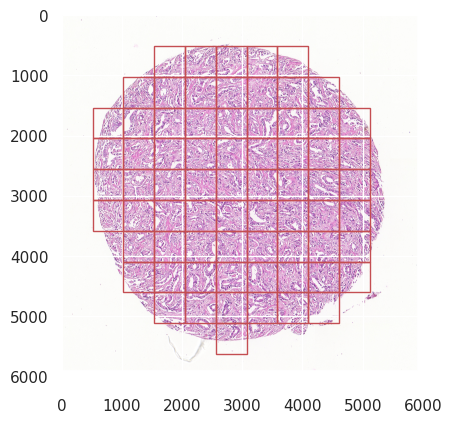

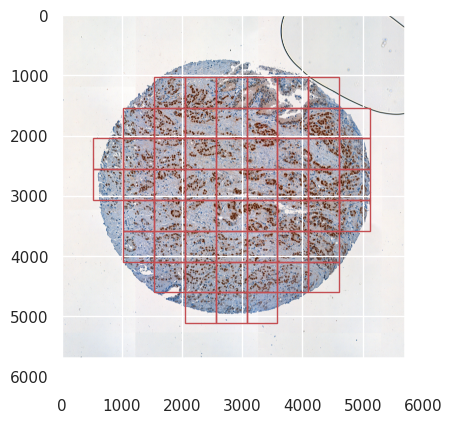

In [5]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

In [6]:
# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Define VAE
# 3. Instantiate the model
vae = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)

In [8]:
vae.count_dtypes()

torch.float32: 26 parameters


In [11]:
test_patch_src = patches_src[10]
test_patch_dst = patches_dst[10]


test_patch_src_tensor = Utilities.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = Utilities.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [13]:
test_patch_src_tensor = test_patch_src_tensor.to(device)

en = vae(test_patch_src_tensor)
en.shape

torch.Size([1, 64, 128, 128])

In [15]:
# Define UNET
# Create model with matching in_channels
model = AdaINUNet(
    in_channels=64,  # Changed from 3 to 64 to match your input
    out_channels=3,
    time_emb_dim=128,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # Creates a model with 4 resolution levels
    num_res_blocks=2,            # 2 residual blocks per resolution
    attention_resolutions=(4, 8),  # Add attention at 8×8 and 16×16 resolutions
    dropout=0.1,
    style_strength=1.0,
    device=device
).to(device)

In [16]:
model.count_dtypes()

torch.float32: 298 parameters


In [17]:
# Define StyleExtractor
extractor = StyleExtractor()
extractor = extractor.to(device='cuda')
encoded = extractor(test_patch_src_tensor)

encoded.view(1, 64, 128, 128).shape

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64, 128, 128])

In [18]:
# Define Decoder
decoder = VanillaDecoder(in_channels=64, latent_dim=64, output_channels=3).to('cuda')  # [1, 64, 64, 64]

In [19]:
pipeline = nn.Sequential(
    vae,
    model,
    decoder
).to(device='cuda')

In [20]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 61412480


In [25]:
count = 0
count_float32 = 0
for name, module in pipeline.named_modules():
    for param_name, param in module.named_parameters(recurse=False):
        # print(f"{name}.{param_name}: dtype={param.dtype}")
        if param.dtype == torch.float32:
            count_float32 += 1
        count += 1

print(f"float32 percentage: {count_float32 / count * 100}%")


float32 percentage: 100.0%


In [ ]:
# Hy[er]